# Imbalanced Data

In [2]:
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [3]:
## HELPER FUNCTIONS

rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

## Credit Card Fraud Detection

In this dataset we get 5 features that are anonimised, so we don't know what they mean. We have to go with the technical characteristics of the data:

- 200200 entries
- 5 feature columns (float)
- 1 target column (int) => [fraudulent, non-fraudulent]

In [5]:
df = pd.read_csv("./data/im_credit.csv", index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200200 entries, 0 to 200199
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V14     200200 non-null  float64
 1   V17     200200 non-null  float64
 2   V4      200200 non-null  float64
 3   V10     200200 non-null  float64
 4   V28     200200 non-null  float64
 5   Class   200200 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 9.2 MB


(Class
 0    200000
 1       200
 Name: count, dtype: int64,
 <Axes: xlabel='Class'>)

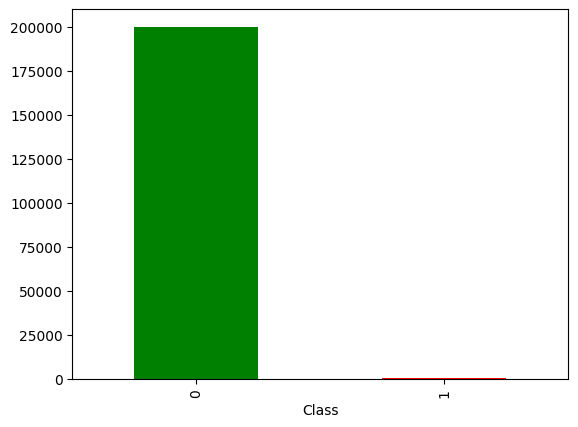

In [8]:
target = 'Class'
features = df.columns.drop(target).to_list()

df[target].value_counts(), df['Class'].value_counts().plot.bar(color=['green', 'red'])

There is a very large imbalance between the fraudulent and non-fraudulent transactions.

In [13]:
X_train, X_test, y_train, y_test = split_data(df)

model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy_score(y_test, preds)

0.9992757242757243

Looking at the accuracy, the model is doing great! However, when considering that most transactions are non-fraudulent, even a model that would always predict non-fraudulent would perform simlarly. 

It is in this case more useful to look at other performance metrics, like:
- Precision -> % of accurately predicted positive instances (TP / (TP+FP)) (related to false positives, so in this case accidentally characterising non-fraudulent as fraudulent)
- Recall -> % of successfully recognised positive instances (TP / (TP+FN)) (related to false negatives, so in this case accidentally mischaracterising fraudulent as non-fraudulent)
- F1Score -> weighted average of precision and recall
- Receiver Operator Characteristic (ROC) -> TP / FP under different thresholds

In [14]:
accuracy = accuracy_score(y_test, preds)
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {fbeta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.72
Recall is: 0.45
Fscore is: 0.46
AUC is: 0.72


Sincde recall measures how often false negatives occur, which is generally much worse (imagine letting fraudulent transactions going through), a recall score of 0.45 is not good.

### Synthetic Minority Oversampling Technique - SMOTE

In SMOTE, many pairs of small clusters with two or more simlar instances are created. Then, by permuting feature values, similar synthetic samples are created. This creates class-balanced synthetic data without adding duplicates.

The `imblearn` package provides multiple samplers, including a `SMOTE` sampler and a `RandomOverSampler`.

<Axes: xlabel='Class'>

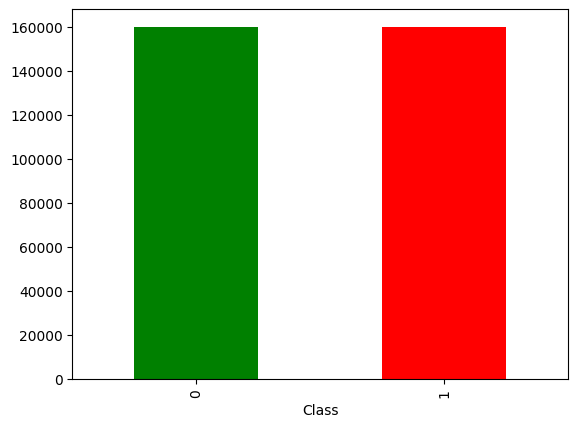

In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

smote_sampler = SMOTE(random_state = rs)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

y_smo.value_counts().plot.bar(color=['green', 'red'])

Now the samples have been resampled to equal occurence. Fitting a model with this dataset shows that F1 score and Recall have improved greatly, but precision is only 3% now. So in terms of overall performance, this is not better.

In [16]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


### Class Reweighting

For binary classification, the loss function is usually a sum of the loss w.r.t. either class. And by default the classes are weighted evenly. However, in the case of extremely skewed data the loss function will unfairly prioritize the majority class, causing model inaccuracies. In this case we can rebalance the loss functions by giving the minority class a higher weight factor.

Class weights can be calculated by:
- Scaling the weights by the proportional mismatch
- Heuristic or domain knowledge. For example making an educated guess on the cost of misclassification.
- Hyper parameter tuning, using grid search with different scaling factors.

In most classifiers in sklearn, the weight can be added to the instantiation of the classifier.

Here we show a demonstration with LogisticRegression using a preset weight of 0.1 vs 0.9

In [17]:
class_weights = {0: 0.1, 1: 0.9}

model = LogisticRegression(random_state=rs, max_iter=1000, class_weight=class_weights)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision, recall, f_beta, support = precision_recall_fscore_support(y_test, y_pred, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


Where we can see that precision and recall is much more balanced. Class reweighting is often the best choice in an extremely skewed dataset as it only scales the response of the model, and leaves the original data intact. Undersampling is another option, but usually this only decreases the amount of data available, not leading to better performance.

To summarize the findings from the credit card fraud detection task:
- All models have very high accuracy and AUC values but this does not always mean they have good prediction performance, especially for classifying the fraud cases
- Classification on an extremly imbalanced dataset is usually a hard task, especially if we want to have both high recall and precision values
- `SMOTE` can achieve high recall but extremely low precision due to the caused disruptions of original data distribution
- Class reweighting can achieve a more balanced recall and precision value


## Utility model training and evaluation methods

This section contains helper functions for:

- Setup and training of logistic regression
- Setup and train random forest
- Evaluating classifier predictions
- Resampling a dataset
- Visualize evaluation metrics

In [19]:
## HELPER FUNCTIONS

rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs, 
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Customer Churn

In [20]:
df = pd.read_csv("./data/im_churn.csv", index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6174 entries, 0 to 6173
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tenure              6174 non-null   int64  
 1   MonthlyCharges      6174 non-null   float64
 2   TotalCharges        6174 non-null   float64
 3   Partner_0           6174 non-null   float64
 4   Partner_1           6174 non-null   float64
 5   Dependents_0        6174 non-null   float64
 6   Dependents_1        6174 non-null   float64
 7   PhoneService_0      6174 non-null   float64
 8   PhoneService_1      6174 non-null   float64
 9   MultipleLines_0     6174 non-null   float64
 10  MultipleLines_1     6174 non-null   float64
 11  MultipleLines_2     6174 non-null   float64
 12  InternetService_0   6174 non-null   float64
 13  InternetService_1   6174 non-null   float64
 14  InternetService_2   6174 non-null   float64
 15  OnlineSecurity_0    6174 non-null   float64
 16  Online

<Axes: xlabel='Class'>

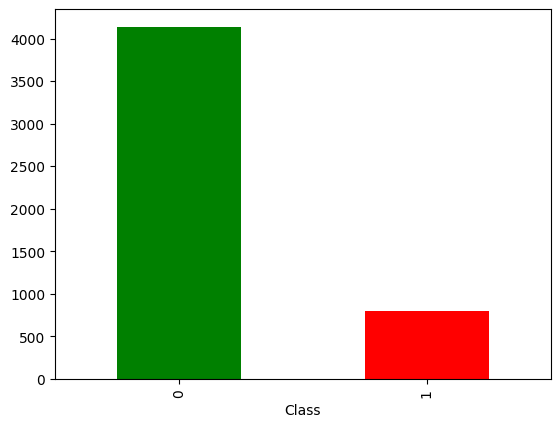

In [21]:
X_train, X_test, y_train, y_test = split_data(df)
y_train.value_counts().plot.bar(color=['green', 'red'])

Again, a imbalanced dataset, though now with only a ratio of ~1:4. Due to the large amount of features we will use a randomforest classifier, coupled with hyperparameter tuning with gridsearch.

In [25]:
# best_params_no_weight = grid_search_rf(X_train, y_train)
# best_params_no_weight['bootstrap'] = True

# best_params_weight = best_params_no_weight.copy()
# best_params_weight['class_weight'] = {0: 0.2, 1:0.8}
# best_params_weight['bootstrap'] = True

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [28]:
# Pre-tuned hyper parameters
best_params_no_weight = {'bootstrap': True,
                         'class_weight': None, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1:0.8}, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

We'll use the best parameters for the following:

- Train a basic RandomForest model with the source data directly.
- Use class reweighting
- Resample using SMOTE 
- Resample using undersampling

            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.839676   0.525  0.712742   0.504808  0.524194
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


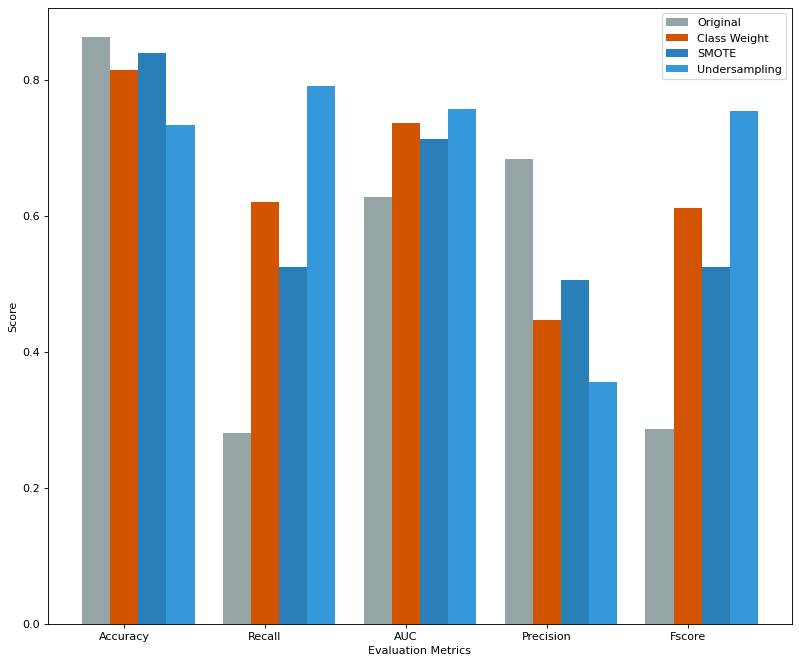

In [29]:
results = []

# No resampling or scaling
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds, "Original")
results.append(result)

# Class reweighting
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
result = evaluate(y_test, preds_cw, "Class Weight")
results.append(result)

# Resampling
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
results.append(result)

preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
results.append(result)

visualize_eval_metrics(results)

- All models have high accuracy
- Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
- AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
- Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
- Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore

By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.

## Tumor Type Estimation

This dataset has high precision, recall and F-score initially without rebalancing the classes.

In [32]:
df = pd.read_csv("./data/im_cancer.csv", index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Clump        664 non-null    int64
 1   UnifSize     664 non-null    int64
 2   UnifShape    664 non-null    int64
 3   MargAdh      664 non-null    int64
 4   SingEpiSize  664 non-null    int64
 5   BareNuc      664 non-null    int64
 6   BlandChrom   664 non-null    int64
 7   NormNucl     664 non-null    int64
 8   Mit          664 non-null    int64
 9   Class        664 non-null    int64
dtypes: int64(10)
memory usage: 52.0 KB


<Axes: xlabel='Class'>

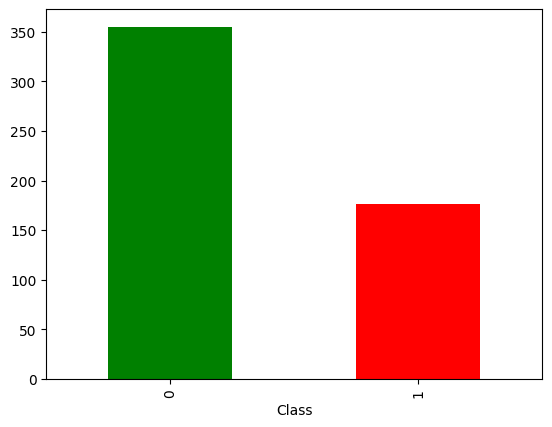

In [34]:
X_train, X_test, y_train, y_test = split_data(df)
y_train.value_counts().plot.bar(color=['green', 'red'])

This data is also much less skewed, with a ratio of ~2:1.

We can use reweighting, SMOTE, undersampling to evaluate performance.

       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


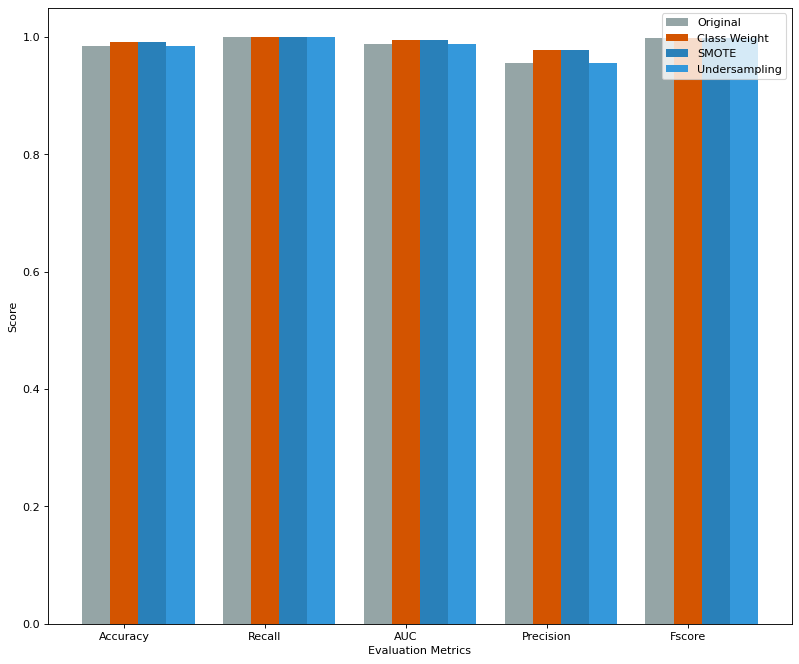

In [35]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

best_params_weight = {
    'bootstrap': True,
    'class_weight': {0: 0.2, 1: 0.8}, 
    'max_depth': 10, 
    'min_samples_split': 5, 
    'n_estimators': 50}

# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))

visualize_eval_metrics(results)

In this case there is almost no improvement, the original setup already provides high accuracy, precision and recall. It might be that the tumor patterns are so clear and neatly segmented that even an unbalanced dataset has no impact on the performance of the trained model.

## Job Change Prediction

In [36]:
df = pd.read_csv("./data/im_hr.csv", index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15781 entries, 0 to 15780
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   city_development_index            15781 non-null  float64
 1   training_hours                    15781 non-null  float64
 2   company_size                      15781 non-null  float64
 3   experience                        15781 non-null  float64
 4   relevent_experience               15781 non-null  float64
 5   education_level                   15781 non-null  float64
 6   company_type_Early Stage Startup  15781 non-null  float64
 7   company_type_Funded Startup       15781 non-null  float64
 8   company_type_NGO                  15781 non-null  float64
 9   company_type_Other                15781 non-null  float64
 10  company_type_Public Sector        15781 non-null  float64
 11  company_type_Pvt Ltd              15781 non-null  float64
 12  gend

<Axes: xlabel='Class'>

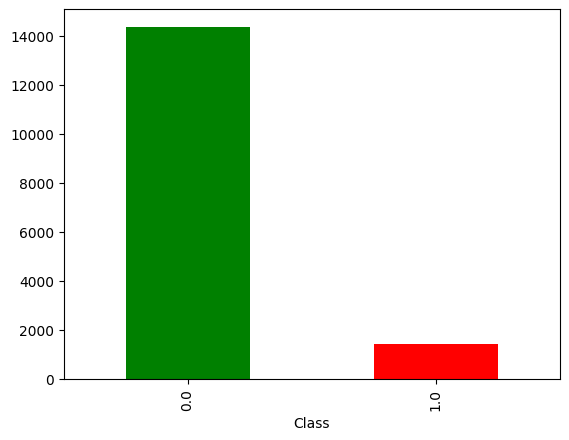

In [39]:
df["Class"].value_counts().plot.bar(color=["green", "red"])

The classes are quite unbalanced, with a ratio of ~10:1. Again, we can use the three different methods from earlier to see if the model performs better with a rebalancing strategy.

           type  accuracy    recall       auc  precision    fscore
0      Original  0.911625  0.003571  0.501786   1.000000  0.003714
1    Reweighted  0.751980  0.585714  0.676938   0.197353  0.544503
2         SMOTE  0.715236  0.607143  0.666449   0.177268  0.555346
3  Undersampled  0.712385  0.614286  0.668109   0.176955  0.560963


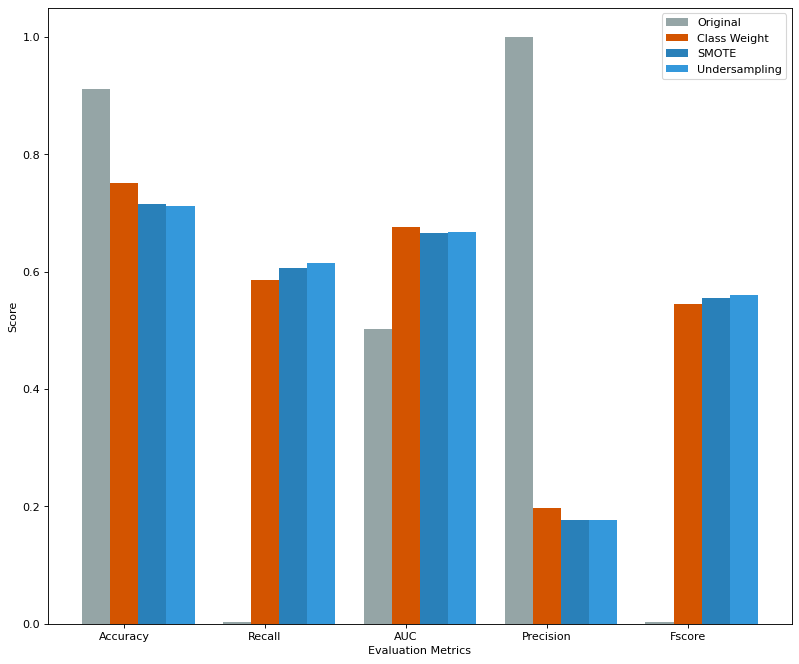

In [42]:
X_train, X_test, y_train, y_test = split_data(df)
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

# no class-weights
results=[]
preds, model = build_lr(X_train, y_train, X_test)
results.append(evaluate(y_test, preds, "Original"))
# class weight
preds, model = build_lr(X_train, y_train, X_test, best_params={'class_weight': {0: 0.1, 1: 0.9}})
results.append(evaluate(y_test, preds, "Reweighted"))
# Resampling
preds, model = build_lr(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds, "SMOTE"))
preds, model = build_lr(X_under, y_under, X_test)
results.append(evaluate(y_test, preds, "Undersampled"))

visualize_eval_metrics(results)